
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain wave families
### In this case, two swell systems, one local sea

inputs required: 
  * Historical wave conditions (GOW2 hindcast)
  * Wave families sectors; the split is based on wave direction
  
in this notebook:
  * Split energy based on defined sectors
  * Remove TC associated waves to avoid double counting 


### Workflow:

<div>
<img src="resources/nb01_09.png" width="300px">
</div>


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import warnings
warnings.filterwarnings('ignore')

# common
import os
import os.path as op
from datetime import datetime

# pip
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.waves import GetDistribution_ws



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/laurac/Dropbox/Majuro_training/teslakit/DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO-training')

In [3]:
# --------------------------------------
# load data and set parameters

WVS_pts = db.Load_WAVES_partitions()  # waves partitions data
WVS_bulk = xr.open_dataset(os.path.join(p_data,'sites','MAJURO-training','WAVES','BULK_SPC_1979_2018.nc'))

_, TCs_r1_params = db.Load_TCs_r1_hist()   # TCs historical parameters inside big radius
_, TCs_r2_params = db.Load_TCs_r2_hist()   # TCs historical parameters inside small radius

# wave families sectors
fams_sectors = [(270, 30), (30, 130), (130, 270)]

# date limits for TCs removal from waves data, and TC time window (hours)
tc_rm_date1 = '1980-01-01'
tc_rm_date2 = '2018-12-31'
tc_time_window = 12


WVS_bulk

<xarray.Dataset>
Dimensions:  (time: 350640)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
    station  int32 ...
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    tm02     (time) float64 ...
    dpm      (time) float64 ...
    dspr     (time) float64 ...


## Calculate Historical Waves Families

In [4]:
# --------------------------------------
# Calculate wave families from waves partitions data and waves sectors

WVS = GetDistribution_ws(WVS_pts, fams_sectors)
WVS=WVS.sel(time=slice(tc_rm_date1,tc_rm_date2))

WVS_bulk=WVS_bulk.sel(time=slice(tc_rm_date1,tc_rm_date2))
WVS['Hs']=WVS_bulk.hs
WVS['Tp']=WVS_bulk.tp
WVS['Dir']=WVS_bulk.dpm

print(WVS)

<xarray.Dataset>
Dimensions:      (time: 341880)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 ... 2018-12-31T23:00:00
    station      int32 ...
Data variables:
    sea_Hs       (time) float64 1.623 1.605 1.57 1.564 ... 2.14 2.125 2.104 2.08
    sea_Tp       (time) float64 9.19 9.188 9.189 9.188 ... 8.959 8.968 8.962
    sea_Dir      (time) float64 53.46 53.4 53.33 53.26 ... 49.9 50.03 49.98
    swell_1_Hs   (time) float64 0.235 0.2334 0.2139 ... 0.4604 0.5088 0.5482
    swell_1_Tp   (time) float64 10.96 10.87 10.62 10.54 ... 15.58 15.44 15.3
    swell_1_Dir  (time) float64 343.5 343.3 339.2 339.1 ... 335.2 335.7 335.9
    swell_2_Hs   (time) float64 nan nan nan nan ... 0.3733 0.3765 0.3655 0.3939
    swell_2_Tp   (time) float64 nan nan nan nan nan ... 8.397 7.725 8.446 8.019
    swell_2_Dir  (time) float64 nan nan nan nan nan ... 117.3 119.2 117.5 117.6
    swell_3_Hs   (time) float64 0.3734 0.3766 0.4521 ... 0.2721 0.2718 0.2726
    swell_3_Tp   (time) float64 11.68

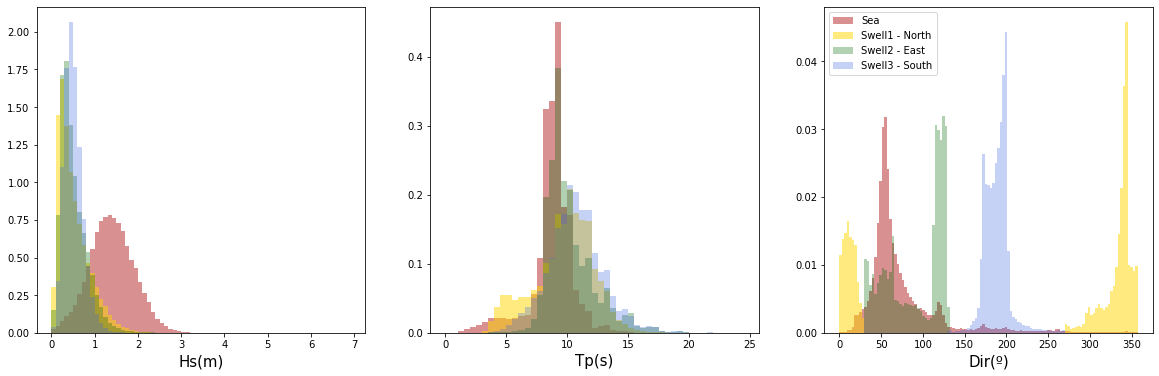

In [5]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=[20,6])
gs3=gridspec.GridSpec(1,3)

ax0=fig.add_subplot(gs3[0])
ax0.hist(WVS.sea_Hs.values,bins=np.arange(0,7,0.1), density=1, color='firebrick', label='Sea', alpha=.5);
ax0.hist(WVS.swell_1_Hs.values,bins=np.arange(0,7,0.1), density=1, color='gold', label='Swell1 - North', alpha=.5);
ax0.hist(WVS.swell_2_Hs.values,bins=np.arange(0,7,0.1), density=1, color='darkgreen', label='Swell2 - East', alpha=.3);
ax0.hist(WVS.swell_3_Hs.values,bins=np.arange(0,7,0.1), density=1, color='royalblue', label='Swell3 - South', alpha=.3);
ax0.set_xlabel('Hs(m)', fontsize=15)

ax0=fig.add_subplot(gs3[1])
ax0.hist(WVS.sea_Tp.values,bins=np.arange(0,25,0.5), density=1, color='firebrick', label='Sea', alpha=.5);
ax0.hist(WVS.swell_1_Tp.values,bins=np.arange(0,25,0.5), density=1, color='gold', label='Swell1 - North', alpha=.5);
ax0.hist(WVS.swell_2_Tp.values,bins=np.arange(0,25,0.5), density=1, color='darkgreen', label='Swell2 - East', alpha=.3);
ax0.hist(WVS.swell_3_Tp.values,bins=np.arange(0,25,0.5), density=1, color='royalblue', label='Swell3 - South', alpha=.3); 
ax0.set_xlabel('Tp(s)', fontsize=15)


ax0=fig.add_subplot(gs3[2])
ax0.hist(WVS.sea_Dir.values,bins=np.arange(0,360,3), density=1, color='firebrick', label='Sea', alpha=.5);
ax0.hist(WVS.swell_1_Dir.values,bins=np.arange(0,360,3), density=1, color='gold', label='Swell1 - North', alpha=.5);
ax0.hist(WVS.swell_2_Dir.values,bins=np.arange(0,360,3), density=1, color='darkgreen', label='Swell2 - East', alpha=.3);
ax0.hist(WVS.swell_3_Dir.values,bins=np.arange(0,360,3), density=1, color='royalblue', label='Swell3 - South', alpha=.3);    
ax0.set_xlabel('Dir(º)', fontsize=15)
ax0.legend()


## TCs: Waves  Selection 

In [6]:
# --------------------------------------
# Locate TCs and set category alongside WAVES data  

# remove TCs before 1979 and after 2015 (r1)
dds = TCs_r1_params.dmin_date.values[:]
ix = np.where((dds >= np.datetime64(tc_rm_date1)) & (dds <= np.datetime64(tc_rm_date2)))[0]
TCs_r1_params = TCs_r1_params.isel(storm=ix)

# select storms inside big circle 
storms_sel = TCs_r1_params.storm.values[:]

# add TCs category alongside WAVES data
WVS['TC_category'] = (('time',), np.empty(len(WVS.time))*np.nan)

for s in storms_sel:

    # waves at storm dates
    ss = TCs_r1_params.sel(storm=s)     
    wvs_s = WVS.sel(time = slice(ss.dmin_date, ss.last_date))
    
    # get hs_max date 
    t_hs_max = wvs_s.where(wvs_s.Hs ==  wvs_s.Hs.max(), drop=True).time.values[:][0]
        
    # hs_max time window 
    w1 = t_hs_max - np.timedelta64(tc_time_window,'h')
    w2 = t_hs_max + np.timedelta64(tc_time_window,'h')
    
    # set category alongside WAVES data
    ixs = np.where((WVS.time >= w1) & (WVS.time <= w2))[0]
    WVS['TC_category'][ixs] = ss.category

print(WVS)
    
# Store historical WAVES data
db.Save_WAVES_hist(WVS)


<xarray.Dataset>
Dimensions:      (time: 341880)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-01 ... 2018-12-31T23:00:00
    station      int32 ...
Data variables:
    sea_Hs       (time) float64 1.623 1.605 1.57 1.564 ... 2.14 2.125 2.104 2.08
    sea_Tp       (time) float64 9.19 9.188 9.189 9.188 ... 8.959 8.968 8.962
    sea_Dir      (time) float64 53.46 53.4 53.33 53.26 ... 49.9 50.03 49.98
    swell_1_Hs   (time) float64 0.235 0.2334 0.2139 ... 0.4604 0.5088 0.5482
    swell_1_Tp   (time) float64 10.96 10.87 10.62 10.54 ... 15.58 15.44 15.3
    swell_1_Dir  (time) float64 343.5 343.3 339.2 339.1 ... 335.2 335.7 335.9
    swell_2_Hs   (time) float64 nan nan nan nan ... 0.3733 0.3765 0.3655 0.3939
    swell_2_Tp   (time) float64 nan nan nan nan nan ... 8.397 7.725 8.446 8.019
    swell_2_Dir  (time) float64 nan nan nan nan nan ... 117.3 119.2 117.5 117.6
    swell_3_Hs   (time) float64 0.3734 0.3766 0.4521 ... 0.2721 0.2718 0.2726
    swell_3_Tp   (time) float64 11.68